In [ ]:
import scipy as sc
import numpy as np
import matplotlib.pyplot as plt
import IRF_Simulator as irfsim
from scipy.interpolate import interp1d
import scipy.signal as sig
import time
import mat73
import time
import os


tic = time.time()

#mcData = mat73.loadmat('DTOFs_2-24-2025_fine.mat')
mcData = mat73.loadmat('DTOFs_2-25-2025_coarseAndWider_1e9.mat')
uas = mcData['ua'].reshape(-1).astype(np.float32)
upss = mcData['ups'].reshape(-1).astype(np.float32)
rhos = mcData['rho'].reshape(-1).astype(np.float32)
dtofs = mcData['DTOF'].astype(np.float32)
cfg = mcData['cfg']

sim_tend = cfg['tend']
target_tend = 25e-9

del mcData

print("Loaded DTOFs from mat file. Number of DTOFs: ", len(uas)*len(upss)*len(rhos))

Loaded DTOFs from mat file. Number of DTOFs:  60000


0.008080808 1.02 30.0


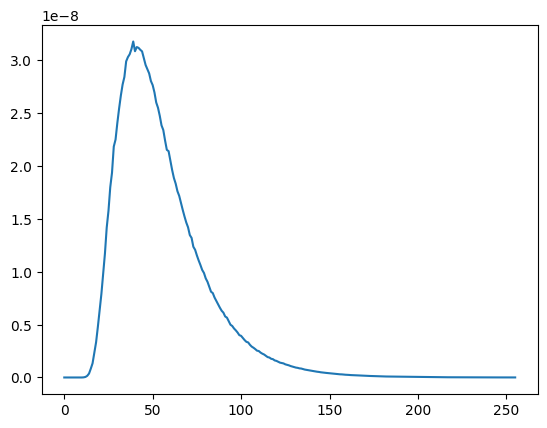

In [24]:
i=40
j=50
k=2
print(uas[i], upss[j], rhos[k])
plt.plot(dtofs[:,i,j,k])

0.0 1.12 30.0


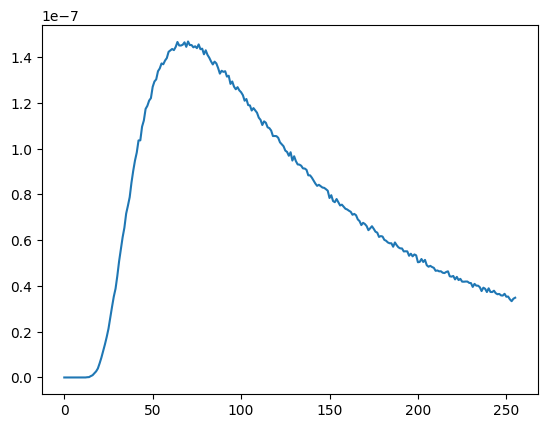

In [25]:
i=0
j=55
k=2
print(uas[i], upss[j], rhos[k])
plt.plot(dtofs[:,i,j,k])

In [26]:
nroOPs = 1
nroIRFs = 2
n_channels = 4096

idrho = 2
rho = rhos[idrho]
print("Selected rho: {} mm ".format(rho))

irf_timeRange_ns = 50
irf_timeResolution_ps = (irf_timeRange_ns/n_channels)*1000
irf_minDelay = 1000

irf_real_proportion = 0
irf_real_samples = np.load('irfs_samples.npy')
print("IRF real samples: ", len(irf_real_samples))

sim_results = []
sim_dtofs = []
sim_irfs = []
sim_irf_norms = []
sim_tags = []
sim_randomsPHD = []
sim_randomsIRF = []
sim_datapoints = []

save_folder = "SIMs"

print('Starting simulation. Number of datapoints: {}...'.format(nroOPs*nroIRFs))

idsim = 0

Selected rho: 30.0 mm 
IRF real samples:  3774
Starting simulation. Number of datapoints: 2...


In [27]:

phd_noise_floor_add_avg = 500
phd_noise_floor_add_sd = 50
phd_noise_floor_mult_avg = 1
phd_noise_floor_mult_sd = 0.02
phd_back_cte_avg = 2e-11
phd_back_cte_sd = 1e-11
phd_nphotons_avg = 2e7
phd_nphotons_sd = 1e6

for iua in range(nroOPs):
    
    idua = np.random.randint(0, len(uas))
    idups = np.random.randint(0, len(upss))
       
    ua = uas[idua]
    ups = upss[idups]
    rho = rhos[idrho]
    
    dtof = dtofs[:, idua, idups, idrho]
    
    if target_tend > sim_tend:
        zoom_factor = int(target_tend/sim_tend)
        new_length = len(dtofs[:,0,0,0])*zoom_factor
        pad_length = new_length - len(dtofs[:,0,0,0])
        dtof = np.pad(dtof, (0, pad_length), 'constant', constant_values=(0, 0))
    
    # Get the current size of dtof
    current_size = dtof.shape[0]

    # Create an array of indices for the current and new sizes
    current_indices = np.arange(current_size)
    new_indices = np.linspace(0, current_size - 1, n_channels)

    # Create an interpolation function
    interpolation_function = interp1d(current_indices, dtof, kind='cubic')

    # Interpolate dtof to the new size
    dtof_interpolated = interpolation_function(new_indices)
    
    for iirf in range(nroIRFs):
        
        idsim += 1
        
        sim_dtofs.append(dtof_interpolated)
        
        irf_real_selected = np.random.rand()
        if irf_real_selected < irf_real_proportion:
            print('{}/{} - ua = {}, ups = {}, rho = {}, using real IRF'.format(idsim, nroOPs*nroIRFs, ua, ups, rho))
            irf_raw = irf_real_samples[np.random.randint(0, len(irf_real_samples))]
            irf = sc.signal.savgol_filter(irf_raw, 10, 3)
            irf = irf-10*np.median(irf)
            irf[irf < 0] = 0
            sim_irfs.append(irf_raw)
        else:
            print('{}/{} - ua = {}, ups = {}, rho = {}, using simulated IRF'.format(idsim, nroOPs*nroIRFs, ua, ups, rho))
            irf_peak_delay1 = int(np.random.normal(5000, 500))
            if irf_peak_delay1 < irf_minDelay: irf_peak_delay1 = irf_minDelay
            irf_peak_delay2 = irf_peak_delay1 + int(np.random.normal(200, 50))
            if irf_peak_delay2 < irf_peak_delay1: irf_peak_delay2 = irf_peak_delay1
            irf_peak_delay3 = irf_peak_delay2 + int(np.random.normal(600, 50))
            if irf_peak_delay3 < irf_peak_delay2: irf_peak_delay3 = irf_peak_delay2
            irf_peak_delay4 = irf_peak_delay3 + int(np.random.normal(200, 50))
            if irf_peak_delay4 < irf_peak_delay3: irf_peak_delay4 = irf_peak_delay3
            
            irf_peak_ratio1 = 1
            irf_peak_ratio2 = np.random.normal(0.6, 0.1)
            if irf_peak_ratio2 < 0: irf_peak_ratio2 = 0
            irf_peak_ratio3 = np.random.normal(0.3, 0.1)
            if irf_peak_ratio3 < 0: irf_peak_ratio3 = 0
            irf_peak_ratio4 = np.random.normal(1, 0.1)
            if irf_peak_ratio4 < 0: irf_peak_ratio4 = 0
            
            irf_peak_width_ps1 = int(np.random.normal(350, 50))
            if irf_peak_width_ps1 < 0: irf_peak_width_ps1 = 0
                                
            irf_peak_width_ps2 = int(np.random.normal(550, 50))
            if irf_peak_width_ps2 < irf_peak_width_ps1: irf_peak_width_ps2 = irf_peak_width_ps1
            
            irf_peak_width_ps3 = int(np.random.normal(700, 100))
            if irf_peak_width_ps3 < irf_peak_width_ps2: irf_peak_width_ps3 = irf_peak_width_ps2
            
            irf_peak_width_ps4 = int(np.random.normal(2500, 200))
            if irf_peak_width_ps4 < irf_peak_width_ps3: irf_peak_width_ps4 = irf_peak_width_ps3
            
            irf_jitter_std_dev_ps = np.random.normal(30, 5)
            
            irf_detector_response_fwhm_ps = np.random.normal(40, 5)
            
            irf_avg_noise_floor = int(np.random.normal(200, 20))
            if irf_avg_noise_floor < 0: irf_avg_noise_floor = 0
            
            irf_sd_noise_floor = int(np.random.normal(20, 5))
            if irf_sd_noise_floor < 0: irf_sd_noise_floor = 0
            
            
            irf_photoncount = int(np.random.normal(1e7, 1e5))
            
            sim_randomsIRF.append([irf_peak_delay1, irf_peak_delay2, irf_peak_delay3, irf_peak_delay4,
                                    irf_peak_ratio1, irf_peak_ratio2, irf_peak_ratio3, irf_peak_ratio4,
                                    irf_peak_width_ps1, irf_peak_width_ps2, irf_peak_width_ps3, irf_peak_width_ps4,
                                    irf_jitter_std_dev_ps, irf_detector_response_fwhm_ps,
                                    irf_avg_noise_floor, irf_sd_noise_floor, irf_photoncount])
            
            irf, irf_times = irfsim.generate_instrument_function_multi_peak(
                                                photon_count=irf_photoncount,   
                                                time_range_ns=irf_timeRange_ns,
                                                time_resolution_ps=irf_timeResolution_ps,
                                                peak_widths_ps=[irf_peak_width_ps1, irf_peak_width_ps2, irf_peak_width_ps3, irf_peak_width_ps4],
                                                jitter_std_dev_ps=irf_jitter_std_dev_ps,
                                                detector_response_type="gaussian",
                                                detector_response_params={'fwhm_ps': irf_detector_response_fwhm_ps},
                                                peak_delays_ps=[irf_peak_delay1, irf_peak_delay2, irf_peak_delay3, irf_peak_delay4],
                                                peak_ratios=[irf_peak_ratio1, irf_peak_ratio2, irf_peak_ratio3, irf_peak_ratio4],
                                                avg_noise_floor=irf_avg_noise_floor,
                                                sd_noise_floor=irf_sd_noise_floor
                                            )
            sim_irfs.append(irf)
            
        irf_norm = irf - np.min(irf)
        
        irf_norm = irf_norm / np.sum(irf_norm)
        
        sim_irf_norms.append(irf_norm)
        
        datapoint = sig.convolve(dtof_interpolated, irf_norm, mode='full')[:len(dtof_interpolated)]

        phd_back_cte = np.random.normal(phd_back_cte_avg, phd_back_cte_sd)
        if phd_back_cte < 0: phd_back_cte = 0
        
        phd_noise_floor_mult = np.random.normal(phd_noise_floor_mult_avg, phd_noise_floor_mult_sd)
        
        phd_noise_floor_add = np.random.normal(phd_noise_floor_add_avg, phd_noise_floor_add_sd)
        if phd_noise_floor_add < 0: phd_noise_floor_add = 0

        phd_nphotons = int(np.random.normal(phd_nphotons_avg, phd_nphotons_sd))
        
        sim_randomsPHD.append([phd_back_cte, phd_noise_floor_mult, phd_noise_floor_add, phd_nphotons])

        datapoint = datapoint + phd_back_cte
        datapoint[datapoint < 0] = 0
        probabilities = datapoint / np.sum(datapoint)
        
        sim_datapoints.append(probabilities)
        
        # Generate random times of flight based on the distribution
        bins = np.arange(len(datapoint))
        simulated_arrival_times = np.random.choice(bins, size=phd_nphotons, p=probabilities)

        simulated_phd = np.histogram(simulated_arrival_times, bins=n_channels, range=(0,n_channels))[0]
        sim_results.append(simulated_phd)
        
        simulated_mult_noise = np.random.normal(loc=phd_noise_floor_mult, scale=0.02, size=n_channels)
        simulated_add_noise = np.random.poisson(lam=phd_noise_floor_add, size=n_channels)
        simulated_phd = simulated_phd*simulated_mult_noise + simulated_add_noise
        simulated_phd[simulated_phd < 0] = 0
        
        sim_tags.append([ua, ups, rho, iirf])
        
        

1/2 - ua = 0.007878787815570831, ups = 0.3799999952316284, rho = 30.0, using simulated IRF


2/2 - ua = 0.007878787815570831, ups = 0.3799999952316284, rho = 30.0, using simulated IRF


In [28]:
sim_tags = np.array(sim_tags)
sim_irfs = np.array(sim_irfs)
sim_results = np.array(sim_results)
sim_randomsPHD = np.array(sim_randomsPHD)
sim_randomsIRF = np.array(sim_randomsIRF)

In [29]:
irf_median = np.median(sim_irfs[0])
print(irf_median)

944.2529756497088


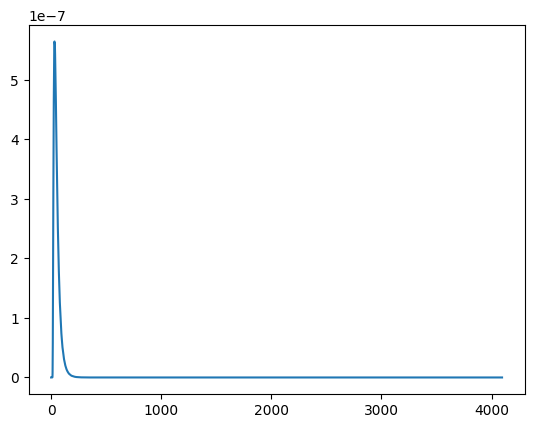

In [35]:
plt.plot(sim_dtofs[0])


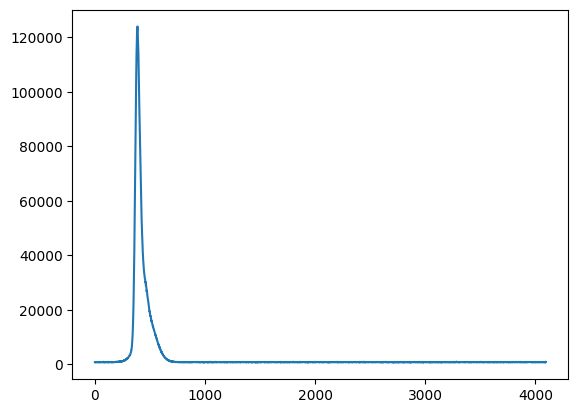

In [31]:
plt.plot(sim_irfs[1])

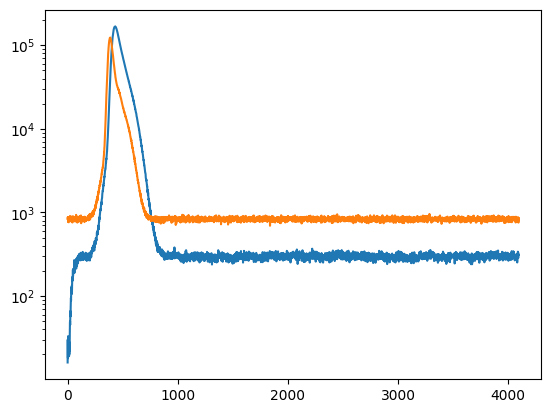

In [32]:
plt.plot(sim_results[1])
plt.plot(sim_irfs[1])
plt.yscale('log')

In [33]:
date_time = time.strftime("%Y%m%d%H%M%S")

save_folder = "SIMs/rho{}mm".format(int(rho))
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

#np.save('{}/sim_tags_{}.npy'.format(save_folder,date_time), sim_tags)
#np.save('{}/sim_irfs_{}.npy'.format(save_folder,date_time), sim_irfs)
#np.save('{}/sim_results_{}.npy'.format(save_folder,date_time), sim_results)
#np.save('{}/sim_randomsPHD_{}.npy'.format(save_folder,date_time), sim_randomsPHD)
#np.save('{}/sim_randomsIRF_{}.npy'.format(save_folder,date_time), sim_randomsIRF)